Using device: cuda
Detected 12 APs.
Applying EMA Smoothing (span=4)...

>>> Start Training RSSI-Model V8 (ResMLP+BiGRU+Attn)...
Epoch 10/150 | Val Loss: 0.00683
Epoch 20/150 | Val Loss: 0.00846
Epoch 30/150 | Val Loss: 0.01048
Epoch 40/150 | Val Loss: 0.01231
Epoch 50/150 | Val Loss: 0.01086
Epoch 60/150 | Val Loss: 0.01264
Epoch 70/150 | Val Loss: 0.01231
Epoch 80/150 | Val Loss: 0.01330
Epoch 90/150 | Val Loss: 0.01118
Epoch 100/150 | Val Loss: 0.01161
Epoch 110/150 | Val Loss: 0.01147
Epoch 120/150 | Val Loss: 0.01194
Epoch 130/150 | Val Loss: 0.01144
Epoch 140/150 | Val Loss: 0.01141
Epoch 150/150 | Val Loss: 0.01118

>>> Evaluating & Smoothing...

Final Results (V8):
  Raw RMSE: 3.1980m
  Smoothed (KF) RMSE: 3.3902m


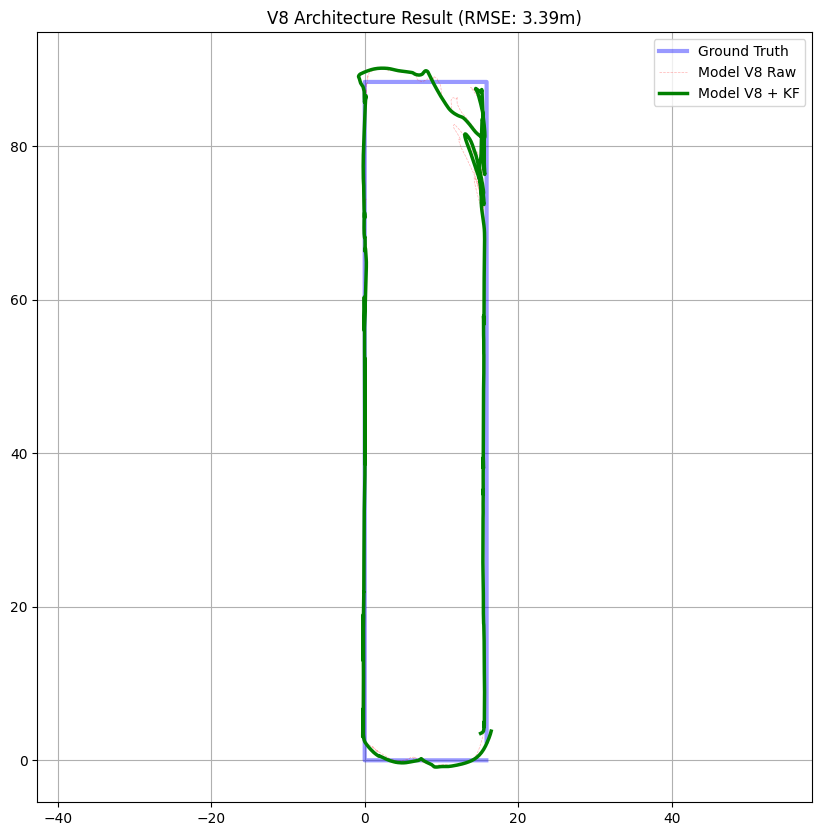

In [2]:
# -*- coding: utf-8 -*-
"""
Zigbee Localization V8: ResMLP + BiGRU + Temporal Attention
-----------------------------------------------------------
抛弃 GNN，采用最适合向量序列的架构。

架构流程:
1. Input: [Batch, Window, Num_APs] (经过 EMA 平滑)
2. Spatial Extractor: ResMLP (将 12维 RSSI 映射为 128维 特征)
3. Temporal Extractor: BiGRU (提取时间演变规律)
4. Fusion: Temporal Attention (自动给每个时间步分配权重，忽略噪声时刻)
5. Output: Coordinate Regression
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 第一部分: 核心组件 (ResBlock & Attention)
# ==============================================================================

class ResidualBlock(nn.Module):
    """
    全连接残差块：用于提取单帧 RSSI 的非线性特征
    Input -> Linear -> BN -> ReLU -> Linear -> BN -> (+Input) -> ReLU
    """
    def __init__(self, hidden_dim, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [Batch * Window, Hidden]
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += residual  # Skip Connection
        out = self.relu(out)
        return out

class TemporalAttention(nn.Module):
    """
    时间注意力机制：给 Window 内的每个时间步打分
    """
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.query = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1, bias=False)
        )

    def forward(self, x):
        # x: [Batch, Window, Hidden]
        # scores: [Batch, Window, 1]
        scores = self.query(x)
        weights = F.softmax(scores, dim=1)
        
        # 加权求和: [Batch, Hidden]
        context = torch.sum(x * weights, dim=1)
        return context, weights

class RSSI_Model_V8(nn.Module):
    def __init__(self, num_aps, window_size, hidden_dim=128):
        super(RSSI_Model_V8, self).__init__()
        
        # 1. Input Projection (将 Num_APs 维映射到 Hidden 维)
        self.input_proj = nn.Sequential(
            nn.Linear(num_aps, hidden_dim),
            nn.ReLU()
        )
        
        # 2. Spatial Feature Extraction (ResMLP)
        # 两个残差块，加深网络
        self.res_block1 = ResidualBlock(hidden_dim)
        self.res_block2 = ResidualBlock(hidden_dim)
        
        # 3. Temporal Feature Extraction (BiGRU)
        # BiGRU 比 LSTM 更适合这种短序列，参数更少更不容易过拟合
        self.gru = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim, # 双向的话输出是 2*Hidden
            num_layers=3,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # 4. Temporal Attention
        # 输入是 BiGRU 的输出 (Hidden * 2)
        self.attn = TemporalAttention(hidden_dim * 2)
        
        # 5. Regression Head
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # x, y
        )

    def forward(self, x):
        # x: [Batch, Window, Num_APs]
        B, W, N = x.shape
        
        # ---------------- Flatten for Spatial Processing ----------------
        # 我们把 Batch 和 Window 维度合并，因为 ResMLP 是单独处理每一帧的
        x_flat = x.view(B * W, N)
        
        # Spatial Encoding
        feat = self.input_proj(x_flat)      # [B*W, Hidden]
        feat = self.res_block1(feat)        # [B*W, Hidden]
        feat = self.res_block2(feat)        # [B*W, Hidden]
        
        # Reshape back to Sequence
        feat_seq = feat.view(B, W, -1)      # [B, W, Hidden]
        
        # ---------------- Temporal Processing ----------------
        # GRU Output: [B, W, Hidden * 2]
        gru_out, _ = self.gru(feat_seq)
        
        # ---------------- Attention Fusion ----------------
        # 自动挑选最重要的一刻，而不是只看最后时刻
        context, attn_weights = self.attn(gru_out) # [B, Hidden * 2]
        
        # ---------------- Regression ----------------
        out = self.regressor(context)
        return out

# ==============================================================================
#                 第二部分: 数据加载 (保持 EMA 平滑)
# ==============================================================================

class RSSIDataset(Dataset):
    def __init__(self, dataframe, wifi_cols, coord_cols, window_size, coord_scaler=None):
        self.window_size = window_size
        self.df = dataframe.reset_index(drop=True)
        self.wifi_cols = wifi_cols
        self.coord_cols = coord_cols
        
        # RSSI 处理: 物理归一化
        wifi_raw = self.df[wifi_cols].values.astype(np.float32)
        wifi_raw[wifi_raw > 0] = -100.0
        wifi_raw = np.clip(wifi_raw, -100.0, 0.0)
        self.wifi_data = (wifi_raw + 100.0) / 100.0
        
        # 坐标处理: StandardScaler
        self.coords = self.df[coord_cols].values.astype(np.float32)
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

def get_data_loaders(config):
    try:
        train_df = pd.read_csv(os.path.join(config['data_dir'], "x_train.csv"), engine='python')
        val_df = pd.read_csv(os.path.join(config['data_dir'], "x_val.csv"), engine='python')
        test_df = pd.read_csv(os.path.join(config['data_dir'], "x_test.csv"), engine='python')
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    wifi_cols = [c for c in train_df.columns if "RSSI" in c or "distance" in c]
    coord_cols = ['x_coord', 'y_coord']
    print(f"Detected {len(wifi_cols)} APs.")

    # 保持 V7 的 EMA 设置，这个对去噪很有用
    print("Applying EMA Smoothing (span=4)...")
    for df in [train_df, val_df, test_df]:
        df[wifi_cols] = df[wifi_cols].ewm(span=4, min_periods=1).mean()

    train_set = RSSIDataset(train_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=None)
    val_set = RSSIDataset(val_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=config['batch_size'], shuffle=False),
        DataLoader(test_set, batch_size=1, shuffle=False),
        len(wifi_cols),
        train_set.coord_scaler
    )

# ==============================================================================
#                 第三部分: 卡尔曼滤波器
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-5, measurement_noise=1.0):
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

# ==============================================================================
#                 第四部分: 主程序
# ==============================================================================

CONFIG = {
    'window_size': 30,     
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'data_dir': '../Datasets/',
    'device': device
}

def main():
    data = get_data_loaders(CONFIG)
    if data is None: return
    train_loader, val_loader, test_loader, num_aps, coord_scaler = data
    
    # 初始化 V8 模型
    model = RSSI_Model_V8(num_aps=num_aps, window_size=CONFIG['window_size']).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    # 依然使用 SmoothL1Loss，稳健回归的首选
    criterion = nn.SmoothL1Loss(beta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
    
    print("\n>>> Start Training RSSI-Model V8 (ResMLP+BiGRU+Attn)...")
    best_loss = float('inf')
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_rssi_v8.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val Loss: {avg_val:.5f}")

    print("\n>>> Evaluating & Smoothing...")
    model.load_state_dict(torch.load('best_rssi_v8.pth'))
    model.eval()
    
    # 稍微调高 KF 信任度，因为 Attn 模型通常预测更准
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=1.0)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            # Input Shape: [1, Window, Num_APs]
            pred = model(x).cpu().numpy()
            
            pred_real = coord_scaler.inverse_transform(pred)[0]
            target_real = coord_scaler.inverse_transform(y.numpy())[0]
            
            preds_raw.append(pred_real)
            targets.append(target_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])

    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    print(f"\nFinal Results (V8):")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed (KF) RMSE: {rmse_smooth:.4f}m")
    
    plt.figure(figsize=(10, 10))
    plt.plot(targets[:, 0], targets[:, 1], 'b-', label='Ground Truth', linewidth=3, alpha=0.4)
    plt.plot(preds_raw[:, 0], preds_raw[:, 1], 'r--', label='Model V8 Raw', linewidth=0.5, alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', label='Model V8 + KF', linewidth=2.5)
    plt.title(f"V8 Architecture Result (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig('Picture/Model_V8_Result.png')
    # print("Plot saved to Picture/Model_V8_Result.png")
    
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets[:,0], 'True_Y': targets[:,1],
        'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
        'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    }).to_csv('results/Zigbee_Cheku.csv', index=False)

if __name__ == '__main__':
    main()
    

Using device: cuda
Detected 12 APs.
Applying EMA Smoothing (span=4)...

>>> Start Training RSSI-Model V8 (ResMLP+BiGRU+Attn)...
Epoch 10/150 | Val Loss: 0.03305
Epoch 20/150 | Val Loss: 0.01871
Epoch 30/150 | Val Loss: 0.00937
Epoch 40/150 | Val Loss: 0.00835
Epoch 50/150 | Val Loss: 0.00676
Epoch 60/150 | Val Loss: 0.00813
Epoch 70/150 | Val Loss: 0.00800
Epoch 80/150 | Val Loss: 0.00607
Epoch 90/150 | Val Loss: 0.00619
Epoch 100/150 | Val Loss: 0.00675
Epoch 110/150 | Val Loss: 0.00540
Epoch 120/150 | Val Loss: 0.00622
Epoch 130/150 | Val Loss: 0.00581
Epoch 140/150 | Val Loss: 0.00522
Epoch 150/150 | Val Loss: 0.00481

>>> Evaluating & Smoothing (with Speed Test)...
Pre-warming model (removing initial latency)...
Warm-up complete.

INFERENCE SPEED REPORT (Zigbee V8)
--------------------------------------------------
Device:               CUDA
Batch Size:           1 (Sequential Mode)
Total Samples:        766
Total Inference Time: 1.2834 s
FPS (Samples/Sec):    596.84
Avg Time per S

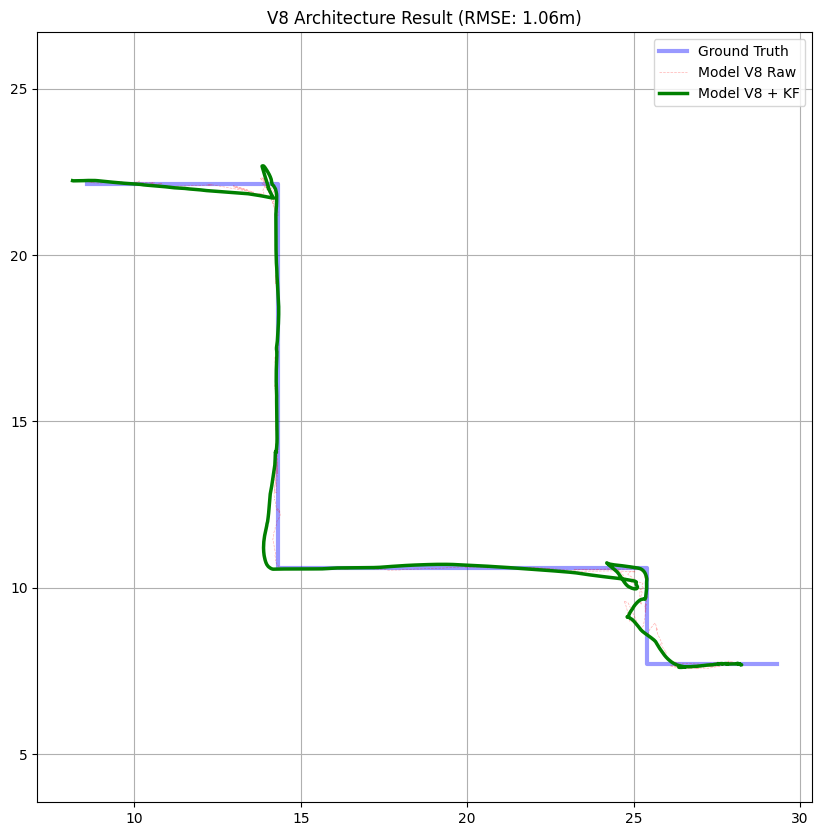

In [1]:
# -*- coding: utf-8 -*-
"""
Zigbee Localization V8: ResMLP + BiGRU + Temporal Attention (含推理测速)
-----------------------------------------------------------
抛弃 GNN，采用最适合向量序列的架构。

架构流程:
1. Input: [Batch, Window, Num_APs] (经过 EMA 平滑)
2. Spatial Extractor: ResMLP (将 12维 RSSI 映射为 128维 特征)
3. Temporal Extractor: BiGRU (提取时间演变规律)
4. Fusion: Temporal Attention (自动给每个时间步分配权重，忽略噪声时刻)
5. Output: Coordinate Regression
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import time  # <--- 【新增】引入 time 模块

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 第一部分: 核心组件 (ResBlock & Attention)
# ==============================================================================

class ResidualBlock(nn.Module):
    """
    全连接残差块：用于提取单帧 RSSI 的非线性特征
    Input -> Linear -> BN -> ReLU -> Linear -> BN -> (+Input) -> ReLU
    """
    def __init__(self, hidden_dim, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [Batch * Window, Hidden]
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += residual  # Skip Connection
        out = self.relu(out)
        return out

class TemporalAttention(nn.Module):
    """
    时间注意力机制：给 Window 内的每个时间步打分
    """
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.query = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1, bias=False)
        )

    def forward(self, x):
        # x: [Batch, Window, Hidden]
        # scores: [Batch, Window, 1]
        scores = self.query(x)
        weights = F.softmax(scores, dim=1)
        
        # 加权求和: [Batch, Hidden]
        context = torch.sum(x * weights, dim=1)
        return context, weights

class RSSI_Model_V8(nn.Module):
    def __init__(self, num_aps, window_size, hidden_dim=128):
        super(RSSI_Model_V8, self).__init__()
        
        # 1. Input Projection (将 Num_APs 维映射到 Hidden 维)
        self.input_proj = nn.Sequential(
            nn.Linear(num_aps, hidden_dim),
            nn.ReLU()
        )
        
        # 2. Spatial Feature Extraction (ResMLP)
        # 两个残差块，加深网络
        self.res_block1 = ResidualBlock(hidden_dim)
        self.res_block2 = ResidualBlock(hidden_dim)
        
        # 3. Temporal Feature Extraction (BiGRU)
        # BiGRU 比 LSTM 更适合这种短序列，参数更少更不容易过拟合
        self.gru = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim, # 双向的话输出是 2*Hidden
            num_layers=3,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # 4. Temporal Attention
        # 输入是 BiGRU 的输出 (Hidden * 2)
        self.attn = TemporalAttention(hidden_dim * 2)
        
        # 5. Regression Head
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # x, y
        )

    def forward(self, x):
        # x: [Batch, Window, Num_APs]
        B, W, N = x.shape
        
        # ---------------- Flatten for Spatial Processing ----------------
        # 我们把 Batch 和 Window 维度合并，因为 ResMLP 是单独处理每一帧的
        x_flat = x.view(B * W, N)
        
        # Spatial Encoding
        feat = self.input_proj(x_flat)      # [B*W, Hidden]
        feat = self.res_block1(feat)        # [B*W, Hidden]
        feat = self.res_block2(feat)        # [B*W, Hidden]
        
        # Reshape back to Sequence
        feat_seq = feat.view(B, W, -1)      # [B, W, Hidden]
        
        # ---------------- Temporal Processing ----------------
        # GRU Output: [B, W, Hidden * 2]
        gru_out, _ = self.gru(feat_seq)
        
        # ---------------- Attention Fusion ----------------
        # 自动挑选最重要的一刻，而不是只看最后时刻
        context, attn_weights = self.attn(gru_out) # [B, Hidden * 2]
        
        # ---------------- Regression ----------------
        out = self.regressor(context)
        return out

# ==============================================================================
#                 第二部分: 数据加载 (保持 EMA 平滑)
# ==============================================================================

class RSSIDataset(Dataset):
    def __init__(self, dataframe, wifi_cols, coord_cols, window_size, coord_scaler=None):
        self.window_size = window_size
        self.df = dataframe.reset_index(drop=True)
        self.wifi_cols = wifi_cols
        self.coord_cols = coord_cols
        
        # RSSI 处理: 物理归一化
        wifi_raw = self.df[wifi_cols].values.astype(np.float32)
        wifi_raw[wifi_raw > 0] = -100.0
        wifi_raw = np.clip(wifi_raw, -100.0, 0.0)
        self.wifi_data = (wifi_raw + 100.0) / 100.0
        
        # 坐标处理: StandardScaler
        self.coords = self.df[coord_cols].values.astype(np.float32)
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

def get_data_loaders(config):
    try:
        train_df = pd.read_csv(os.path.join(config['data_dir'], "zoulang/train.csv"), engine='python')
        val_df = pd.read_csv(os.path.join(config['data_dir'], "zoulang/validation.csv"), engine='python')
        test_df = pd.read_csv(os.path.join(config['data_dir'], "zoulang/test.csv"), engine='python')
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    wifi_cols = [c for c in train_df.columns if "RSSI" in c or "distance" in c]
    coord_cols = ['x_coord', 'y_coord']
    print(f"Detected {len(wifi_cols)} APs.")

    # 保持 V7 的 EMA 设置，这个对去噪很有用
    print("Applying EMA Smoothing (span=4)...")
    for df in [train_df, val_df, test_df]:
        df[wifi_cols] = df[wifi_cols].ewm(span=4, min_periods=1).mean()

    train_set = RSSIDataset(train_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=None)
    val_set = RSSIDataset(val_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=config['batch_size'], shuffle=False),
        # 注意：这里 batch_size=1 是为了模拟逐条跟踪，这会影响 FPS 数值 (Sequential Processing)
        DataLoader(test_set, batch_size=1, shuffle=False),
        len(wifi_cols),
        train_set.coord_scaler
    )

# ==============================================================================
#                 第三部分: 卡尔曼滤波器
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-5, measurement_noise=1.0):
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

# ==============================================================================
#                 第四部分: 主程序
# ==============================================================================

CONFIG = {
    'window_size': 30,      
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'data_dir': '../Datasets/',
    'device': device
}

def main():
    data = get_data_loaders(CONFIG)
    if data is None: return
    train_loader, val_loader, test_loader, num_aps, coord_scaler = data
    
    # 初始化 V8 模型
    model = RSSI_Model_V8(num_aps=num_aps, window_size=CONFIG['window_size']).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    # 依然使用 SmoothL1Loss，稳健回归的首选
    criterion = nn.SmoothL1Loss(beta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
    
    print("\n>>> Start Training RSSI-Model V8 (ResMLP+BiGRU+Attn)...")
    best_loss = float('inf')
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_rssi_v8.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val Loss: {avg_val:.5f}")

    print("\n>>> Evaluating & Smoothing (with Speed Test)...")
    model.load_state_dict(torch.load('best_rssi_v8.pth'))
    model.eval()
    
    # --- 【新增】 1. 预热 (Warm-up) ---
    print("Pre-warming model (removing initial latency)...")
    dummy_input = torch.zeros((1, CONFIG['window_size'], num_aps)).to(device)
    with torch.no_grad():
        _ = model(dummy_input)
    print("Warm-up complete.")

    # 稍微调高 KF 信任度，因为 Attn 模型通常预测更准
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=1.0)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    # --- 【新增】 2. 计时变量 ---
    total_inference_time = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            # Input Shape: [1, Window, Num_APs]
            
            # --- 【新增】 3. 精准计时开始 ---
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t0 = time.time()
            
            pred = model(x) # 纯模型推理
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t1 = time.time()
            total_inference_time += (t1 - t0)
            total_samples += x.size(0)
            # --- 【新增】 计时结束 ---

            pred_np = pred.cpu().numpy()
            pred_real = coord_scaler.inverse_transform(pred_np)[0]
            target_real = coord_scaler.inverse_transform(y.numpy())[0]
            
            preds_raw.append(pred_real)
            targets.append(target_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])

    # --- 【新增】 4. 输出速度报告 ---
    avg_time_ms = (total_inference_time / total_samples) * 1000
    fps = total_samples / total_inference_time

    print("\n" + "="*50)
    print(f"INFERENCE SPEED REPORT (Zigbee V8)")
    print("-" * 50)
    print(f"Device:               {device.type.upper()}")
    print(f"Batch Size:           {test_loader.batch_size} (Sequential Mode)")
    print(f"Total Samples:        {total_samples}")
    print(f"Total Inference Time: {total_inference_time:.4f} s")
    print(f"FPS (Samples/Sec):    {fps:.2f}")
    print(f"Avg Time per Sample:  {avg_time_ms:.4f} ms")
    print("="*50 + "\n")

    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    print(f"Final Results (V8):")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed (KF) RMSE: {rmse_smooth:.4f}m")
    
    plt.figure(figsize=(10, 10))
    plt.plot(targets[:, 0], targets[:, 1], 'b-', label='Ground Truth', linewidth=3, alpha=0.4)
    plt.plot(preds_raw[:, 0], preds_raw[:, 1], 'r--', label='Model V8 Raw', linewidth=0.5, alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', label='Model V8 + KF', linewidth=2.5)
    plt.title(f"V8 Architecture Result (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig('Picture/Model_V8_Result.png')
    # print("Plot saved to Picture/Model_V8_Result.png")
    
    os.makedirs('results', exist_ok=True)
    # pd.DataFrame({
    #     'True_X': targets[:,0], 'True_Y': targets[:,1],
    #     'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
    #     'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    # }).to_csv('results/Zigbee_Cheku.csv', index=False)
    # print(f"Results saved to results/Zigbee_Cheku.csv")

if __name__ == '__main__':
    main()

Using device: cuda
Aligned Features: 12 APs
Applying EMA Smoothing (span=4)...
Initializing V10 (Conv1d + Attention + BiGRU)...

>>> Start Training V10...
Epoch 10/150 | Val Loss: 0.01647
Epoch 20/150 | Val Loss: 0.01643
Epoch 30/150 | Val Loss: 0.01214
Epoch 40/150 | Val Loss: 0.01111
Epoch 50/150 | Val Loss: 0.00907
Epoch 60/150 | Val Loss: 0.00958
Epoch 70/150 | Val Loss: 0.00849
Epoch 80/150 | Val Loss: 0.00999
Epoch 90/150 | Val Loss: 0.00754
Epoch 100/150 | Val Loss: 0.00833
Epoch 110/150 | Val Loss: 0.00821
Epoch 120/150 | Val Loss: 0.00909
Epoch 130/150 | Val Loss: 0.00819
Epoch 140/150 | Val Loss: 0.00812
Epoch 150/150 | Val Loss: 0.00889

>>> Testing & Smoothing (Strong KF)...

Final V10 Results:
  Raw RMSE: 4.1007m
  Smoothed RMSE: 3.7322m
Plot saved.


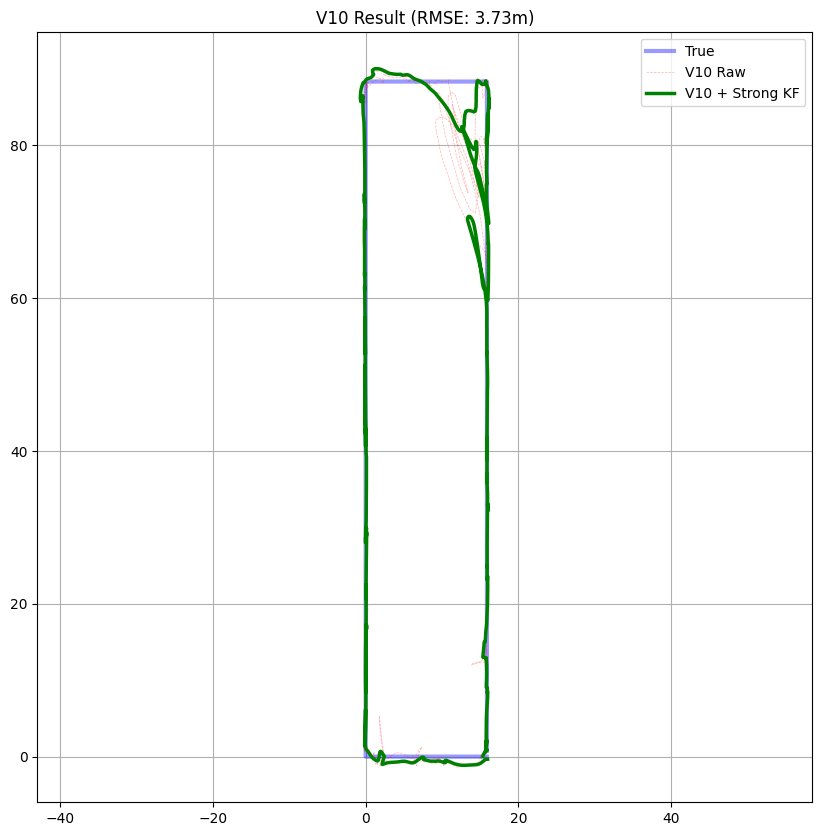

In [ ]:
# -*- coding: utf-8 -*-
"""
Zigbee Localization V10: Conv1d-Smoothing + BiGRU + Attention
-------------------------------------------------------------
回归稳健性，针对 V9 的抖动问题进行修复。
1. Input: 使用 Conv1d 进行时序特征提取和降噪 (替代不稳定的 RBF)。
2. Feature: Channel Attention 保留，用于筛选有效 AP。
3. Temporal: BiGRU (双向 GRU) 提取长时依赖。
4. Smoothing: 强力卡尔曼滤波参数。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 配置部分
# ==============================================================================
CONFIG = {
    'data_dir': '../Datasets/zoulang',
    'train_file': 'train.csv',
    'val_file': 'validation.csv',
    'test_file': 'test.csv',
    
    'window_size': 10,      
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'device': device
}

# ==============================================================================
#                 第一部分: 模型定义 (V10 架构)
# ==============================================================================

class ChannelAttention(nn.Module):
    """通道注意力：筛选重要的 AP"""
    def __init__(self, input_dim, reduction=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(input_dim // reduction, input_dim, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [Batch, Window, Dim]
        # Global Average Pooling over time: [Batch, Dim]
        avg_out = torch.mean(x, dim=1)
        w = self.fc(avg_out).unsqueeze(1) # [Batch, 1, Dim]
        return x * w

class RSSI_Model_V10(nn.Module):
    def __init__(self, num_aps, window_size, hidden_dim=128):
        super(RSSI_Model_V10, self).__init__()
        
        # 1. Temporal Convolution (时序卷积降噪)
        # 将输入看作 [Batch, Channels=Num_APs, Length=Window]
        # 作用：平滑时间序列上的毛刺
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=num_aps, out_channels=hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # 2. Channel Attention
        self.chan_attn = ChannelAttention(hidden_dim)
        
        # 3. Bi-GRU
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=2, # 2层足够了，太深容易过拟合
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # 4. Temporal Attention (提取关键时刻)
        self.temp_query = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1, bias=False)
        )
        
        # 5. Regressor
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.GELU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        # x: [Batch, Window, Num_APs]
        
        # --- 1. Conv1d Smoothing ---
        # 变换维度适配 Conv1d: [B, N, W]
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)
        # 变换回: [B, W, Hidden]
        x = x.permute(0, 2, 1)
        
        # --- 2. Channel Attention ---
        x = self.chan_attn(x)
        
        # --- 3. Bi-GRU ---
        # out: [B, W, Hidden*2]
        out, _ = self.gru(x)
        
        # --- 4. Temporal Attention ---
        # scores: [B, W, 1]
        scores = self.temp_query(out)
        weights = F.softmax(scores, dim=1)
        # context: [B, Hidden*2]
        context = torch.sum(out * weights, dim=1)
        
        # --- 5. Regression ---
        coords = self.regressor(context)
        return coords

# ==============================================================================
#                 第二部分: 数据加载 (保持稳健的 V8/V9 逻辑)
# ==============================================================================

class RSSIDataset(Dataset):
    def __init__(self, dataframe, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = dataframe.reset_index(drop=True)
        
        wifi_data = self.df[wifi_cols].values.astype(np.float32)
        coords = self.df[coord_cols].values.astype(np.float32)
        
        # 物理归一化 (-100 ~ 0 -> 0 ~ 1)
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi_data = (wifi_data + 100.0) / 100.0
        
        self.coords = coords # 先不归一化，下面处理
        
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

def get_data_loaders(config):
    train_path = os.path.join(config['data_dir'], config['train_file'])
    val_path = os.path.join(config['data_dir'], config['val_file'])
    test_path = os.path.join(config['data_dir'], config['test_file'])

    if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print("Error: Data files missing.")
        return None

    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    # 特征对齐
    def get_wifi_cols(df):
        return set([c for c in df.columns if "RSSI" in c or "distance" in c])
    
    common_wifi = list(get_wifi_cols(train_df).intersection(get_wifi_cols(val_df)).intersection(get_wifi_cols(test_df)))
    common_wifi.sort()
    coord_cols = ['x_coord', 'y_coord']
    
    print(f"Aligned Features: {len(common_wifi)} APs")
    if len(common_wifi) == 0: return None

    # EMA 平滑
    print("Applying EMA Smoothing (span=4)...")
    for df in [train_df, val_df, test_df]:
        df[common_wifi] = df[common_wifi].ewm(span=4, min_periods=1).mean()

    train_set = RSSIDataset(train_df, common_wifi, coord_cols, config['window_size'], coord_scaler=None)
    val_set = RSSIDataset(val_df, common_wifi, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, common_wifi, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=config['batch_size'], shuffle=False),
        DataLoader(test_set, batch_size=1, shuffle=False),
        len(common_wifi),
        train_set.coord_scaler
    )

# ==============================================================================
#                 第三部分: 强力卡尔曼滤波 (Parameter Tuning)
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-5, measurement_noise=2.0): 
        # [重要调整] 
        # measurement_noise 从 0.5 -> 2.0
        # 含义：我们不太信任模型的单次预测（因为它可能抖动），我们更信任物体运动的连续性。
        # 这会产生强烈的平滑效果，把锯齿拉直。
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

# ==============================================================================
#                 第四部分: 主程序
# ==============================================================================

def main():
    data = get_data_loaders(CONFIG)
    if data is None: return
    train_loader, val_loader, test_loader, num_aps, coord_scaler = data
    
    # 初始化 V10
    print("Initializing V10 (Conv1d + Attention + BiGRU)...")
    model = RSSI_Model_V10(num_aps=num_aps, window_size=CONFIG['window_size']).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.SmoothL1Loss(beta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    
    best_loss = float('inf')
    
    print(f"\n>>> Start Training V10...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_rssi_v10.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val Loss: {avg_val:.5f}")

    # 评估
    print("\n>>> Testing & Smoothing (Strong KF)...")
    model.load_state_dict(torch.load('best_rssi_v10.pth'))
    model.eval()
    
    # 使用调优后的 KF
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=2.0)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            pred_real = coord_scaler.inverse_transform(pred)[0]
            target_real = coord_scaler.inverse_transform(y.numpy())[0]
            
            preds_raw.append(pred_real)
            targets.append(target_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])

    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    print(f"\nFinal V10 Results:")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed RMSE: {rmse_smooth:.4f}m")
    
    # 保存
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets[:,0], 'True_Y': targets[:,1],
        'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
        'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    }).to_csv('results/Model_V10_Predictions.csv', index=False)
    
    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(targets[:, 0], targets[:, 1], 'b-', label='True', linewidth=3, alpha=0.4)
    plt.plot(preds_raw[:, 0], preds_raw[:, 1], 'r--', label='V10 Raw', linewidth=0.5, alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', label='V10 + Strong KF', linewidth=2.5)
    plt.title(f"V10 Result (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    plt.savefig('Picture/Model_V10_Result.png')
    print("Plot saved.")

if __name__ == '__main__':
    main()

Using device: cuda
Features: 6 APs
Applying EMA (span=4)...

Initializing V11 (ResNet + Transformer)...

>>> Start Training V11...


c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 10/20 | Val Loss: 0.01429
Epoch 20/20 | Val Loss: 0.01272

>>> Testing & Smoothing...

Final V11 Results:
  Raw RMSE: 1.1962m
  Smoothed RMSE: 0.8294m
  Jerk (Smoothed): 0.05 m/s^3
Plot saved.


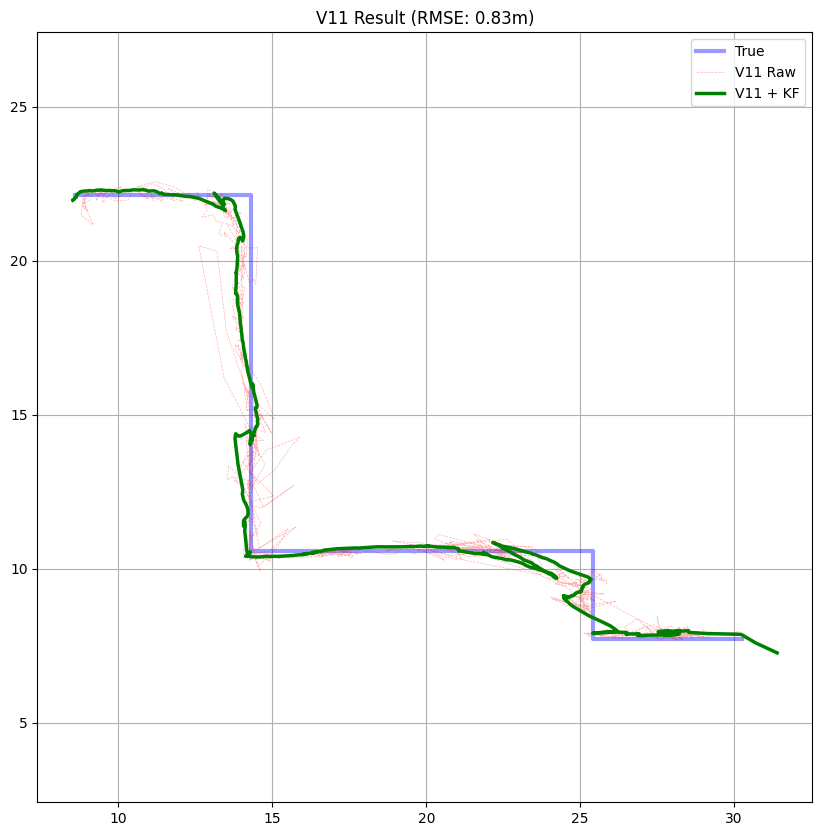

In [ ]:
# -*- coding: utf-8 -*-
"""
Zigbee Localization V11: ResNet-Transformer Hybrid
--------------------------------------------------
突破 RNN 瓶颈，采用 SOTA 时序架构。
1. Frontend: Deep ResNet-1D (提取抗噪的局部波形特征)
2. Backend: Transformer Encoder (利用全局注意力解决滞后与漂移)
3. Head: Global Average Pooling + MLP
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import math

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 第一部分: V11 核心组件 (ResNet + Transformer)
# ==============================================================================

class ResNetBlock1D(nn.Module):
    """一维残差块：深层特征提取的关键"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        padding = (kernel_size - 1) // 2
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.act = nn.GELU()
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # 如果输入输出维度不一致，需要投影映射
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        # x: [Batch, Channel, Time]
        residual = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.act(out)
        return out

class PositionalEncoding(nn.Module):
    """可学习的位置编码"""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model) * 0.02)

    def forward(self, x):
        # x: [Batch, Seq, Dim]
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class RSSI_Model_V11(nn.Module):
    def __init__(self, num_aps, window_size, d_model=128, nhead=4, num_layers=2):
        super(RSSI_Model_V11, self).__init__()
        
        # 1. Frontend: ResNet-1D
        # 输入: [Batch, Num_APs, Window] -> 类似图像的 Channel=AP, Width=Time
        # 我们通过 ResNet 提取更高级的特征，并保持时间维度(Window)不变或略微缩减
        self.frontend = nn.Sequential(
            # Entry Flow
            nn.Conv1d(num_aps, 64, kernel_size=1), # 升维
            nn.BatchNorm1d(64),
            nn.GELU(),
            
            # Deep Residual Blocks
            ResNetBlock1D(64, 64),
            ResNetBlock1D(64, 128, stride=2), # 下采样时间维度，增加感受野
            ResNetBlock1D(128, d_model)       # 输出通道 = d_model (为Transformer准备)
        )
        
        # 2. Backend: Transformer Encoder
        self.pos_encoder = PositionalEncoding(d_model, max_len=window_size)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model * 4,
            dropout=0.1,
            activation='gelu',
            batch_first=True,
            norm_first=True # Pre-LN 训练更稳定
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Head
        self.pool = nn.AdaptiveAvgPool1d(1) # Global Average Pooling
        self.head = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2) # x, y
        )

    def forward(self, x):
        # x: [Batch, Window, Num_APs]
        
        # --- 1. ResNet Feature Extraction ---
        # 调整维度适配 Conv1d: [B, C=APs, L=Window]
        x = x.permute(0, 2, 1) 
        x = self.frontend(x) 
        # ResNet 输出: [B, d_model, Reduced_Window]
        
        # --- 2. Transformer Modeling ---
        # 调整维度适配 Transformer: [B, Seq, Dim]
        x = x.permute(0, 2, 1)
        x = self.pos_encoder(x)
        x = self.transformer(x) # [B, Seq, Dim]
        
        # --- 3. Prediction ---
        # 调整回: [B, Dim, Seq] 以进行 Pooling
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1) # [B, Dim]
        
        out = self.head(x)
        return out

# ==============================================================================
#                 第二部分: 配置与数据加载 (保持 V10 的最佳实践)
# ==============================================================================

CONFIG = {
    'data_dir': '../Datasets/zoulang',
    'train_file': 'train.csv',
    'val_file': 'validation.csv',
    'test_file': 'test.csv',
    
    'window_size': 5,      # 保持 30 的敏捷窗口
    'batch_size': 64,
    'lr': 0.001,            # Transformer 可以承受稍大的 LR
    'epochs': 20,
    'device': device
}

class RSSIDataset(Dataset):
    def __init__(self, dataframe, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = dataframe.reset_index(drop=True)
        
        wifi_data = self.df[wifi_cols].values.astype(np.float32)
        coords = self.df[coord_cols].values.astype(np.float32)
        
        # 物理归一化
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi_data = (wifi_data + 100.0) / 100.0
        
        self.coords = coords
        
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

def get_data_loaders(config):
    try:
        train_df = pd.read_csv(os.path.join(config['data_dir'], config['train_file']))
        val_df = pd.read_csv(os.path.join(config['data_dir'], config['val_file']))
        test_df = pd.read_csv(os.path.join(config['data_dir'], config['test_file']))
    except Exception as e:
        print(f"Error: {e}")
        return None

    # 特征对齐
    def get_wifi_cols(df):
        # return set([c for c in df.columns if "RSSI" in c or "distance" in c])
        return set([c for c in df.columns if "RSSI" in c ])
    
    common_wifi = list(get_wifi_cols(train_df).intersection(get_wifi_cols(val_df)).intersection(get_wifi_cols(test_df)))
    common_wifi.sort()
    coord_cols = ['x_coord', 'y_coord']
    print(f"Features: {len(common_wifi)} APs")

    # EMA 平滑
    print("Applying EMA (span=4)...")
    for df in [train_df, val_df, test_df]:
        df[common_wifi] = df[common_wifi].ewm(span=4, min_periods=1).mean()

    train_set = RSSIDataset(train_df, common_wifi, coord_cols, config['window_size'], coord_scaler=None)
    val_set = RSSIDataset(val_df, common_wifi, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, common_wifi, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=config['batch_size'], shuffle=False),
        DataLoader(test_set, batch_size=1, shuffle=False),
        len(common_wifi),
        train_set.coord_scaler
    )

# ==============================================================================
#                 第三部分: 强力卡尔曼滤波
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-5, measurement_noise=2.0): 
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

# ==============================================================================
#                 第四部分: 主程序
# ==============================================================================

def main():
    data = get_data_loaders(CONFIG)
    if data is None: return
    train_loader, val_loader, test_loader, num_aps, coord_scaler = data
    
    print("\nInitializing V11 (ResNet + Transformer)...")
    model = RSSI_Model_V11(
        num_aps=num_aps, 
        window_size=CONFIG['window_size'], 
        d_model=128, 
        nhead=8,
        num_layers=1 
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.SmoothL1Loss(beta=1.0)
    # 使用 CosineAnnealing 调度器，更适合 Transformer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    best_loss = float('inf')
    
    print(f"\n>>> Start Training V11...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        scheduler.step() # Cosine需要在每个epoch后更新
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_loader)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_rssi_v11.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val Loss: {avg_val:.5f}")

    # 评估
    print("\n>>> Testing & Smoothing...")
    model.load_state_dict(torch.load('best_rssi_v11.pth'))
    model.eval()
    
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=2.0)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            pred_real = coord_scaler.inverse_transform(pred)[0]
            target_real = coord_scaler.inverse_transform(y.numpy())[0]
            
            preds_raw.append(pred_real)
            targets.append(target_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])

    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    # Jerk (dt=0.05)
    dt = 1
    vel = np.diff(preds_smooth, axis=0) / dt
    acc = np.diff(vel, axis=0) / dt
    jerk = np.diff(acc, axis=0) / dt
    mean_jerk = np.mean(np.linalg.norm(jerk, axis=1))
    
    print(f"\nFinal V11 Results:")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed RMSE: {rmse_smooth:.4f}m")
    print(f"  Jerk (Smoothed): {mean_jerk:.2f} m/s^3")
    
    # 保存
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets[:,0], 'True_Y': targets[:,1],
        'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
        'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    }).to_csv('results/Zigbee_UWP.csv', index=False)
    
    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(targets[:, 0], targets[:, 1], 'b-', label='True', linewidth=3, alpha=0.4)
    plt.plot(preds_raw[:, 0], preds_raw[:, 1], 'r--', label='V11 Raw', linewidth=0.5, alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', label='V11 + KF', linewidth=2.5)
    plt.title(f"V11 Result (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig('Picture/Model_V11_Result.png')
    # print("Plot saved.")

if __name__ == '__main__':
    main()

In [22]:
# -*- coding: utf-8 -*-
"""
Zigbee Localization V8: ResMLP + BiGRU + Temporal Attention (Single File Version)
-------------------------------------------------------------------------------
修改说明：
1. 数据加载：改为读取单个数据集文件 (CONFIG['filename'])。
2. 数据切分：自动按 8:1:1 的比例顺序切分训练、验证和测试集。
3. 标准化：严格只在训练集上 fit，防止数据泄露。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 配置部分
# ==============================================================================
CONFIG = {
    'data_dir': '../Datasets/',
    'filename': '0.45_Speed_withoutOB.csv', # [修改] 指定单个文件名
    
    'window_size': 60,      
    'batch_size': 128,
    'lr': 1e-3,
    'epochs': 100,
    'patience': 15,
    'device': device
}

# ==============================================================================
#                 第一部分: 核心组件 (ResBlock & Attention)
# ==============================================================================

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += residual  
        out = self.relu(out)
        return out

class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.query = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1, bias=False)
        )

    def forward(self, x):
        scores = self.query(x)
        weights = F.softmax(scores, dim=1)
        context = torch.sum(x * weights, dim=1)
        return context, weights

class RSSI_Model_V8(nn.Module):
    def __init__(self, num_aps, window_size, hidden_dim=128):
        super(RSSI_Model_V8, self).__init__()
        
        self.input_proj = nn.Sequential(
            nn.Linear(num_aps, hidden_dim),
            nn.ReLU()
        )
        
        self.res_block1 = ResidualBlock(hidden_dim)
        self.res_block2 = ResidualBlock(hidden_dim)
        
        self.gru = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim, 
            num_layers=3,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        self.attn = TemporalAttention(hidden_dim * 2)
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2) 
        )

    def forward(self, x):
        B, W, N = x.shape
        x_flat = x.view(B * W, N)
        
        feat = self.input_proj(x_flat)
        feat = self.res_block1(feat)
        feat = self.res_block2(feat)
        
        feat_seq = feat.view(B, W, -1)
        
        gru_out, _ = self.gru(feat_seq)
        context, attn_weights = self.attn(gru_out)
        out = self.regressor(context)
        return out

# ==============================================================================
#                 第二部分: 数据加载 (核心修改: 单文件切分)
# ==============================================================================

def load_and_process_data():
    # 1. 读取单个文件
    file_path = os.path.join(CONFIG['data_dir'], CONFIG['filename'])
    
    if not os.path.exists(file_path):
        print(f"错误: 找不到文件 {file_path}")
        return None, None, None, None, None

    print(f"Loading data from {file_path}...")
    full_df = pd.read_csv(file_path)
    
    # 2. 按顺序切分数据集 (80% 训练, 10% 验证, 10% 测试)
    # 注意：必须保持时间顺序，不能 shuffle
    total_len = len(full_df)
    train_end = int(total_len * 0.8)
    val_end = int(total_len * 0.9)
    
    print(f"Total samples: {total_len}")
    print(f"Split: Train(0-{train_end}), Val({train_end}-{val_end}), Test({val_end}-{total_len})")
    
    # 使用 .iloc 进行切分并 copy，避免 SettingWithCopyWarning
    train_df = full_df.iloc[:train_end].copy()
    val_df = full_df.iloc[train_end:val_end].copy()
    test_df = full_df.iloc[val_end:].copy()
    
    # 3. 自动识别特征 (基于训练集)
    coord_cols = ['x_coord', 'y_coord']
    try:
        feature_candidates = train_df.drop(['timestamp'] + coord_cols, axis=1, errors='ignore').columns.tolist()
    except KeyError:
        feature_candidates = train_df.columns.tolist()

    # 这里的逻辑是：只要列名包含 rssi/distance/rot 就认为是 WiFi 特征
    # 只要包含 acc/gyr/mag 就认为是 IMU 特征 (虽然 V8 模型主要用 RSSI，但这里保留逻辑通用性)
    wifi_features = [col for col in feature_candidates if any(x in col.lower() for x in ["rssi", "distance", "rot"])]
    
    # V8 模型其实只用了 wifi_features 作为输入维度，这里我们只提取 WiFi 列
    print(f"Identified {len(wifi_features)} WiFi features.")
    
    if len(wifi_features) == 0:
        print("Error: No WiFi columns found!")
        return None, None, None, None, None

    # 4. EMA 平滑 (保持开启，这对去噪很重要)
    # 分别对切分后的数据做平滑，防止未来数据泄露
    print("Applying EMA Smoothing (span=4)...")
    for df in [train_df, val_df, test_df]:
        df[wifi_features] = df[wifi_features].ewm(span=4, min_periods=1).mean()

    # 5. 标准化 (StandardScaler)
    # [关键] 只在训练集上 fit，防止数据泄露
    scaler_wifi = StandardScaler().fit(train_df[wifi_features])
    scaler_coords = StandardScaler().fit(train_df[coord_cols])
    
    # 应用 transform 到所有集
    train_df_scaled = train_df.copy()
    val_df_scaled = val_df.copy()
    test_df_scaled = test_df.copy()

    for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
        df[wifi_features] = scaler_wifi.transform(df[wifi_features])
        df[coord_cols] = scaler_coords.transform(df[coord_cols])
        
    # 返回处理后的 DataFrame 和 scaler
    return train_df_scaled, val_df_scaled, test_df_scaled, wifi_features, scaler_coords

class RSSIDataset(Dataset):
    def __init__(self, df, wifi_cols, coord_cols, window_size):
        self.window_size = window_size
        self.wifi_data = torch.tensor(df[wifi_cols].values, dtype=torch.float32)
        self.coords = torch.tensor(df[coord_cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.wifi_data) - self.window_size

    def __getitem__(self, idx):
        # Input: [Window, Features]
        x = self.wifi_data[idx : idx + self.window_size]
        # Target: [2] (取窗口最后一个时间步的坐标)
        y = self.coords[idx + self.window_size - 1]
        return x, y

def get_data_loaders():
    # 调用上面的函数处理数据
    train_df, val_df, test_df, wifi_cols, scaler = load_and_process_data()
    
    if train_df is None: return None

    coord_cols = ['x_coord', 'y_coord']

    # 创建 Dataset
    train_set = RSSIDataset(train_df, wifi_cols, coord_cols, CONFIG['window_size'])
    val_set = RSSIDataset(val_df, wifi_cols, coord_cols, CONFIG['window_size'])
    test_set = RSSIDataset(test_df, wifi_cols, coord_cols, CONFIG['window_size'])

    return (
        DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=CONFIG['batch_size'], shuffle=False),
        DataLoader(test_set, batch_size=1, shuffle=False), # Batch=1 for testing
        len(wifi_cols),
        scaler
    )

# ==============================================================================
#                 第三部分: 卡尔曼滤波器
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-5, measurement_noise=1.0):
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

# ==============================================================================
#                 第四部分: 主程序
# ==============================================================================

def main():
    # 1. 加载数据
    data = get_data_loaders()
    if data is None: return
    train_loader, val_loader, test_loader, num_aps, coord_scaler = data
    
    # 2. 初始化模型
    model = RSSI_Model_V8(num_aps=num_aps, window_size=CONFIG['window_size']).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.SmoothL1Loss(beta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
    
    print("\n>>> Start Training RSSI-Model V8 (ResMLP+BiGRU+Attn)...")
    best_loss = float('inf')
    
    # 3. 训练循环
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_rssi_v8.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val Loss: {avg_val:.5f}")

    print("\n>>> Evaluating & Smoothing...")
    model.load_state_dict(torch.load('best_rssi_v8.pth'))
    model.eval()
    
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=1.0)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            
            pred_real = coord_scaler.inverse_transform(pred)[0]
            target_real = coord_scaler.inverse_transform(y.numpy())[0]
            
            preds_raw.append(pred_real)
            targets.append(target_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])

    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    print(f"\nFinal Results (V8):")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed (KF) RMSE: {rmse_smooth:.4f}m")
    
    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(targets[:, 0], targets[:, 1], 'b-', label='Ground Truth', linewidth=3, alpha=0.4)
    plt.plot(preds_raw[:, 0], preds_raw[:, 1], 'r--', label='Model V8 Raw', linewidth=0.5, alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', label='Model V8 + KF', linewidth=2.5)
    plt.title(f"V8 Architecture Result (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    plt.savefig('Picture/Model_V8_Result.png')
    print("Plot saved to Picture/Model_V8_Result.png")
    
    # [新增] 动态生成保存文件名
    save_name = f"results/V8_{CONFIG['filename']}"
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets[:,0], 'True_Y': targets[:,1],
        'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
        'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    }).to_csv(save_name, index=False)
    print(f"Predictions saved to {save_name}")

if __name__ == '__main__':
    main()

Using device: cuda
Loading data from ../Datasets/0.45_Speed_withoutOB.csv...
Total samples: 19359
Split: Train(0-15487), Val(15487-17423), Test(17423-19359)
Identified 13 WiFi features.
Applying EMA Smoothing (span=4)...

>>> Start Training RSSI-Model V8 (ResMLP+BiGRU+Attn)...


KeyboardInterrupt: 

In [1]:
# -*- coding: utf-8 -*-
"""
Zigbee Localization V11 (Single File): ResNet-Transformer Hybrid
----------------------------------------------------------------
突破 RNN 瓶颈，采用 SOTA 时序架构。
1. Frontend: Deep ResNet-1D (提取抗噪的局部波形特征)
2. Backend: Transformer Encoder (利用全局注意力解决滞后与漂移)
3. Head: Global Average Pooling + MLP
4. Data: 单文件读取 + 自动切分 (8:1:1)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import math

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 第一部分: V11 核心组件 (ResNet + Transformer)
# ==============================================================================

class ResNetBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        padding = (kernel_size - 1) // 2
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.act = nn.GELU()
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.act(out)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model) * 0.02)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class RSSI_Model_V11(nn.Module):
    def __init__(self, num_aps, window_size, d_model=128, nhead=4, num_layers=2):
        super(RSSI_Model_V11, self).__init__()
        
        self.frontend = nn.Sequential(
            nn.Conv1d(num_aps, 64, kernel_size=1), 
            nn.BatchNorm1d(64),
            nn.GELU(),
            ResNetBlock1D(64, 64),
            ResNetBlock1D(64, 128, stride=2), 
            ResNetBlock1D(128, d_model)       
        )
        
        self.pos_encoder = PositionalEncoding(d_model, max_len=window_size)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model * 4,
            dropout=0.1,
            activation='gelu',
            batch_first=True,
            norm_first=True 
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pool = nn.AdaptiveAvgPool1d(1) 
        self.head = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2) 
        )

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.frontend(x) 
        x = x.permute(0, 2, 1)
        x = self.pos_encoder(x)
        x = self.transformer(x) 
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1) 
        out = self.head(x)
        return out

# ==============================================================================
#                 第二部分: 配置与数据加载 (单文件版)
# ==============================================================================

CONFIG = {
    'data_dir': '../Datasets/',
    'filename': '0.45_Speed_withoutOB.csv', # [修改] 使用单个文件名
    
    'window_size': 20,     # V11 推荐稍小的窗口
    'batch_size': 64,
    'lr': 0.001,           
    'epochs': 100,
    'device': device
}

class RSSIDataset(Dataset):
    def __init__(self, df, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = df.reset_index(drop=True)
        
        wifi_data = self.df[wifi_cols].values.astype(np.float32)
        coords = self.df[coord_cols].values.astype(np.float32)
        
        # 物理归一化
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi_data = (wifi_data + 100.0) / 100.0
        
        self.coords = coords
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

def get_data_loaders(config):
    # 1. 读取单个文件
    file_path = os.path.join(config['data_dir'], config['filename'])
    
    if not os.path.exists(file_path):
        print(f"Error: Data file not found at {file_path}")
        return None

    print(f"Loading data from {file_path}...")
    full_df = pd.read_csv(file_path)
    
    # 2. 按顺序切分 (80% / 10% / 10%)
    n = len(full_df)
    train_end = int(n * 0.8)
    val_end = int(n * 0.9)
    
    print(f"Total samples: {n}")
    print(f"Split: Train(0-{train_end}), Val({train_end}-{val_end}), Test({val_end}-{n})")
    
    # copy() 防止警告
    train_df = full_df.iloc[:train_end].copy()
    val_df = full_df.iloc[train_end:val_end].copy()
    test_df = full_df.iloc[val_end:].copy()

    # 3. 特征识别
    # 只要列名包含 rssi/distance/rot 就认为是 WiFi 特征
    # (根据你的数据情况，V11 主要靠 RSSI，这里提取包含 RSSI 的列)
    cols = train_df.columns
    wifi_cols = [c for c in cols if "RSSI" in c or "distance" in c or "rot" in c]
    coord_cols = ['x_coord', 'y_coord']
    
    print(f"Features: {len(wifi_cols)} APs")
    if len(wifi_cols) == 0:
        print("Error: No WiFi columns found!")
        return None

    # 4. EMA 平滑 (分别对切分后的数据做，防止泄露)
    print("Applying EMA Smoothing (span=4)...")
    for df in [train_df, val_df, test_df]:
        df[wifi_cols] = df[wifi_cols].ewm(span=4, min_periods=1).mean()

    # 5. 创建 Dataset
    # Val 和 Test 使用 Train 的 Scaler
    train_set = RSSIDataset(train_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=None)
    val_set = RSSIDataset(val_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, wifi_cols, coord_cols, config['window_size'], coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=config['batch_size'], shuffle=False),
        DataLoader(test_set, batch_size=1, shuffle=False),
        len(wifi_cols),
        train_set.coord_scaler
    )

# ==============================================================================
#                 第三部分: 强力卡尔曼滤波
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-5, measurement_noise=2.0): 
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

# ==============================================================================
#                 第四部分: 主程序
# ==============================================================================

def main():
    # 1. 加载数据
    data = get_data_loaders(CONFIG)
    if data is None: return
    train_loader, val_loader, test_loader, num_aps, coord_scaler = data
    
    # 2. 初始化模型
    print("\nInitializing V11 (ResNet + Transformer)...")
    model = RSSI_Model_V11(
        num_aps=num_aps, 
        window_size=CONFIG['window_size'], 
        d_model=128, 
        nhead=8,
        num_layers=2 
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.SmoothL1Loss(beta=1.0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    best_loss = float('inf')
    
    print(f"\n>>> Start Training V11...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        scheduler.step() 
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_loader)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_rssi_v11.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val Loss: {avg_val:.5f}")

    # 3. 评估
    print("\n>>> Testing & Smoothing...")
    model.load_state_dict(torch.load('best_rssi_v11.pth'))
    model.eval()
    
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=2.0)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            
            pred_real = coord_scaler.inverse_transform(pred)[0]
            target_real = coord_scaler.inverse_transform(y.numpy())[0]
            
            preds_raw.append(pred_real)
            targets.append(target_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])

    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    # Jerk (assuming dt=1 for consistency with previous metrics, adjust if needed)
    dt = 1.0 
    vel = np.diff(preds_smooth, axis=0) / dt
    acc = np.diff(vel, axis=0) / dt
    jerk = np.diff(acc, axis=0) / dt
    mean_jerk = np.mean(np.linalg.norm(jerk, axis=1))
    
    print(f"\nFinal V11 Results:")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed RMSE: {rmse_smooth:.4f}m")
    print(f"  Jerk (Smoothed): {mean_jerk:.2f} m/s^3")
    
    # 保存
    os.makedirs('results', exist_ok=True)
    save_name = f"results/Zigbee_{CONFIG['filename']}"
    pd.DataFrame({
        'True_X': targets[:,0], 'True_Y': targets[:,1],
        'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
        'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    }).to_csv(save_name, index=False)
    print(f"Predictions saved to {save_name}")
    
    # 绘图
    plt.figure(figsize=(10, 10))
    plt.plot(targets[:, 0], targets[:, 1], 'b-', label='Ground Truth', linewidth=3, alpha=0.4)
    plt.plot(preds_raw[:, 0], preds_raw[:, 1], 'r--', label='V11 Raw', linewidth=0.5, alpha=0.3)
    plt.plot(preds_smooth[:, 0], preds_smooth[:, 1], 'g-', label='V11 + KF', linewidth=2.5)
    plt.title(f"V11 Result (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig('Picture/Model_V11_Result.png')
    # print("Plot saved.")

if __name__ == '__main__':
    main()

Using device: cuda
Loading data from ../Datasets/0.45_Speed_withoutOB.csv...
Total samples: 19359
Split: Train(0-15487), Val(15487-17423), Test(17423-19359)
Features: 13 APs
Applying EMA Smoothing (span=4)...

Initializing V11 (ResNet + Transformer)...


c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



>>> Start Training V11...
Epoch 10/100 | Val Loss: 0.39476
Epoch 20/100 | Val Loss: 0.39202


KeyboardInterrupt: 